In [1]:
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping
import keras.optimizers
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from keras.applications import vgg16
import numpy as np
import random
import os
import pickle
import cv2
import torch
import random
import pandas as pd
from PIL import Image as Image
from tqdm import tqdm
from glob import glob
from typing import *
from IPython.display import Image as IPImage
from sklearn.model_selection import train_test_split
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

In [2]:
# Get Dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3035 (from 1)
Receiving objects: 100% (3039/3039), 79.25 MiB | 22.26 MiB/s, done.
Updating files: 100% (3264/3264), done.


In [14]:
image_path = "/content/Brain-Tumor-Classification-DataSet/Training"
image_path2= "/content/Brain-Tumor-Classification-DataSet/Testing"

In [30]:
label_encoder = LabelEncoder()

origin_train_df = pd.read_csv(os.path.join(image_path, "training_data.txt"), names=["path"])
origin_train_df["label"] = origin_train_df["path"].apply(lambda x: x.split('/')[-2])
origin_train_df["label"] = label_encoder.fit_transform(origin_train_df["label"])
origin_train_df["path"] = origin_train_df["path"].apply(lambda x: os.path.join(image_path,x))
origin_train_df

# training_df = pd.read_csv(f"{image_path}/training_data.txt", names=["path"])
# training_df["label"] = training_df["path"].apply(lambda x: x.split('/')[-2])
# training_df["label"] = label_encoder.fit_transform(training_df["label"])
# training_df["path"] = training_df["path"].apply(lambda x: os.path.join(image_path,x))
# training_df

glioma_tumor/gg (1).jpg
glioma_tumor/gg (1).jpg
/content/Brain-Tumor-Classification-DataSet/Training/glioma_tumor/gg (1).jpg


In [10]:
origin_train_df.path[0]

'/content/Brain-Tumor-Classification-DataSet/Training/glioma_tumor/gg (1).jpg'

In [ ]:
test_df = pd.read_csv(f"{image_path2}/testing_data.txt", names=["path"])
test_df["label"] = test_df["path"].apply(lambda x: x.split('/')[-2])
test_df["label"] = label_encoder.fit_transform(test_df["label"])
test_df["path"] = image_path2 + "/" + test_df["path"]
test_df

,path,label
0,/content/Brain-Tumor-Classification-DataSet/Te...,0
1,/content/Brain-Tumor-Classification-DataSet/Te...,0
2,/content/Brain-Tumor-Classification-DataSet/Te...,0
3,/content/Brain-Tumor-Classification-DataSet/Te...,0
4,/content/Brain-Tumor-Classification-DataSet/Te...,0
...,...,...
389,/content/Brain-Tumor-Classification-DataSet/Te...,3
390,/content/Brain-Tumor-Classification-DataSet/Te...,3
391,/content/Brain-Tumor-Classification-DataSet/Te...,3
392,/content/Brain-Tumor-Classification-DataSet/Te...,3


In [ ]:
# train 데이터셋을 8:2로 나눠서 valid를 하도록 하겠습니다
train_df, valid_df = train_test_split(
    origin_train_df,
    test_size=0.2,
    random_state=0,
    shuffle=True,
    stratify=origin_train_df["label"],
)

In [ ]:
# 사용자 정의 데이터셋 클래스 생성 (CustomDataset)
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # 데이터셋 초기화
        # dataframe: 이미지 경로와 레이블이 포함된 데이터프레임
        # transform: 이미지에 적용할 전처리(transform) 함수
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        # 이미지 경로를 데이터프레임에서 가져옴
        img_name = self.dataframe.iloc[idx, 0]
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # 레이블 정보를 정수형으로 가져옴
        label = int(self.dataframe.iloc[idx, 1])

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 레이블을 반환
        return img, label

In [ ]:
channel_means = [0.5043, 0.5043, 0.5043]
channel_stds = [0.1801, 0.1801, 0.1801]

# 채널 평균 및 표준편차를 0~1 사이의 값으로 정규화
normalized_channel_means = [x / 255 for x in channel_means]
normalized_channel_stds = [x / 255 for x in channel_stds]

# 이미지 전처리를 위한 변환 작업 정의.
# transforms.Normalize 이전에 이미 픽셀값은 0~1 사이로 정규화 되어 있습니다.
# 따라서 기존의 0~255 픽셀값 기준에서 도출된 channel_means, channel_stds 도 0~1 사이 값으로 정규화 된 normalized_channel_means, normalized_channel_stds 로 변환하여 사용합니다
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalized_channel_means, std=normalized_channel_stds),
])

# 코랩의 GPU 환경은 실행시마다 바뀔 수 있습니다.
# 혹시 메모리 에러가 난다면 batch size를 줄여서 학습을 시도해 볼 수 있습니다.
batch_size = 256

# 데이터셋 로딩
train_dataset = CustomDataset(dataframe=train_df, transform=transform)
valid_dataset = CustomDataset(dataframe=valid_df, transform=transform)
test_dataset = CustomDataset(dataframe=test_df, transform=transform)

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# 사전 학습된 ResNet18 모델 불러오기
model = models.resnet18(pretrained=True)

# 모델의 마지막 완전 연결 계층(fc)을 사용자 정의 계층으로 대체
# 이 계층은 in_features에서 10개의 출력으로 매핑합니다 (10개 클래스 분류를 위함)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
)

# 교차 엔트로피 손실 함수 초기화
criterion = nn.CrossEntropyLoss()
# 최적화 알고리즘으로 Adam 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]


In [ ]:
# 학습 파라미터 설정
num_epochs = 50  # 학습 반복 횟수
best_val_acc = 0.0  # 최상의 검증 정확도를 저장하는 변수
patience = 5  # 얼리 스탑핑을 위한 patience 설정 (개선되지 않은 횟수)
no_improve = 0  # 개선되지 않은 에포크 수를 카운트하는 변수

for epoch in range(num_epochs):

    # 모델을 학습 모드로 전환
    model.train()
    running_loss = 0.0  # 에포크 동안의 총 손실을 저장하는 변수
    correct_train = 0  # 정확하게 예측한 학습 데이터의 개수를 저장하는 변수
    total_train = 0  # 총 학습 데이터 개수를 저장하는 변수

    # 학습 데이터를 반복하여 모델 업데이트
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        # 데이터를 장치로 이동 (GPU 또는 CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()
        # 모델에 입력을 전달하여 예측값 출력
        outputs = model(inputs)
        # 손실 함수 계산
        loss = criterion(outputs, labels)
        # 손실에 대한 역전파 수행 (기울기 계산)
        loss.backward()
        # 옵티마이저를 통해 모델 파라미터 업데이
        optimizer.step()
        # 현재 배치의 손실을 누적
        running_loss += loss.item()

        # 정확도 계산을 위한 예측값 처리
        _, predicted = torch.max(outputs.data, 1) # 최대값을 가지는 클래스 예측
        total_train += labels.size(0) # 총 학습 데이터 수 누적
        correct_train += (predicted == labels).sum().item() # 맞춘 예측의 개수 누적

    # 에포크별 학습 정확도와 손실 계산
    train_acc = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validate
    model.eval()  # 모델을 평가 모드로 전환 (드롭아웃, 배치 정규화 등 비활성화)
    running_val_loss = 0.0  # 검증 손실을 저장하는 변수
    correct_val = 0  # 정확하게 예측한 검증 데이터의 개수를 저장하는 변수
    total_val = 0  # 총 검증 데이터 개수를 저장하는 변수
    with torch.no_grad(): # 검증 시에는 기울기를 계산하지 않음 (메모리 및 계산량 절약)
        for inputs, labels in valid_loader:
            # 데이터를 장치로 이동
            inputs, labels = inputs.to(device), labels.to(device)
            # 모델에 입력을 전달하여 예측값 출력
            outputs = model(inputs)
            # 손실 함수 계산
            loss = criterion(outputs, labels)
            # 현재 배치의 손실을 누적
            running_val_loss += loss.item()

            # 정확도 계산을 위한 예측값 처리
            _, predicted = torch.max(outputs.data, 1)  # 최대값을 가지는 클래스 예측
            total_val += labels.size(0)  # 총 검증 데이터 수 누적
            correct_val += (predicted == labels).sum().item()  # 맞춘 예측의 개수 누적

    # 에포크별 검증 정확도와 손실 계산
    val_acc = correct_val / total_val  # 검증 정확도 계산
    val_loss = running_val_loss / len(valid_loader)  # 검증 손실 평균 계산

    # 학습 및 검증 결과 출력
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

     # 최상의 검증 정확도를 기록하고 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_before.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:  # 설정한 얼리 스타핑 patience에 도달하면 학습을 중단합니다.
            print("Early stopping")
            break

print('Finished Training')

Epoch 1/50: 100%|██████████| 9/9 [00:16<00:00,  1.80s/it]


Train Loss: 2.2196, Train Accuracy: 0.2400, Validation Loss: 2.2472, Validation Accuracy: 0.2038


Epoch 2/50: 100%|██████████| 9/9 [00:15<00:00,  1.72s/it]


Train Loss: 1.8034, Train Accuracy: 0.4861, Validation Loss: 1.7132, Validation Accuracy: 0.5645


Epoch 3/50: 100%|██████████| 9/9 [00:15<00:00,  1.77s/it]


Train Loss: 1.4506, Train Accuracy: 0.7147, Validation Loss: 1.3437, Validation Accuracy: 0.7666


Epoch 4/50: 100%|██████████| 9/9 [00:15<00:00,  1.68s/it]


Train Loss: 1.1585, Train Accuracy: 0.8118, Validation Loss: 1.0833, Validation Accuracy: 0.8153


Epoch 5/50: 100%|██████████| 9/9 [00:15<00:00,  1.72s/it]


Train Loss: 0.9321, Train Accuracy: 0.8406, Validation Loss: 0.8982, Validation Accuracy: 0.8362


Epoch 6/50: 100%|██████████| 9/9 [00:15<00:00,  1.69s/it]


Train Loss: 0.7586, Train Accuracy: 0.8645, Validation Loss: 0.7732, Validation Accuracy: 0.8380


Epoch 7/50: 100%|██████████| 9/9 [00:15<00:00,  1.75s/it]


Train Loss: 0.6311, Train Accuracy: 0.8811, Validation Loss: 0.6820, Validation Accuracy: 0.8449


Epoch 8/50: 100%|██████████| 9/9 [00:14<00:00,  1.61s/it]


Train Loss: 0.5382, Train Accuracy: 0.8955, Validation Loss: 0.6111, Validation Accuracy: 0.8554


Epoch 9/50: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Train Loss: 0.4593, Train Accuracy: 0.9107, Validation Loss: 0.5574, Validation Accuracy: 0.8624


Epoch 10/50: 100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


Train Loss: 0.3997, Train Accuracy: 0.9229, Validation Loss: 0.5125, Validation Accuracy: 0.8780


Epoch 11/50: 100%|██████████| 9/9 [00:13<00:00,  1.54s/it]


Train Loss: 0.3525, Train Accuracy: 0.9312, Validation Loss: 0.4739, Validation Accuracy: 0.8833


Epoch 12/50: 100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


Train Loss: 0.3102, Train Accuracy: 0.9386, Validation Loss: 0.4442, Validation Accuracy: 0.8885


Epoch 13/50: 100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


Train Loss: 0.2750, Train Accuracy: 0.9486, Validation Loss: 0.4198, Validation Accuracy: 0.8972


Epoch 14/50: 100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


Train Loss: 0.2400, Train Accuracy: 0.9573, Validation Loss: 0.3950, Validation Accuracy: 0.9094


Epoch 15/50: 100%|██████████| 9/9 [00:13<00:00,  1.49s/it]


Train Loss: 0.2160, Train Accuracy: 0.9660, Validation Loss: 0.3757, Validation Accuracy: 0.9094


Epoch 16/50: 100%|██████████| 9/9 [00:13<00:00,  1.50s/it]


Train Loss: 0.1900, Train Accuracy: 0.9730, Validation Loss: 0.3574, Validation Accuracy: 0.9129


Epoch 17/50: 100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


Train Loss: 0.1692, Train Accuracy: 0.9787, Validation Loss: 0.3427, Validation Accuracy: 0.9164


Epoch 18/50: 100%|██████████| 9/9 [00:14<00:00,  1.57s/it]


Train Loss: 0.1515, Train Accuracy: 0.9817, Validation Loss: 0.3311, Validation Accuracy: 0.9146


Epoch 19/50: 100%|██████████| 9/9 [00:14<00:00,  1.65s/it]


Train Loss: 0.1341, Train Accuracy: 0.9887, Validation Loss: 0.3192, Validation Accuracy: 0.9146


Epoch 20/50: 100%|██████████| 9/9 [00:13<00:00,  1.54s/it]


Train Loss: 0.1217, Train Accuracy: 0.9895, Validation Loss: 0.3085, Validation Accuracy: 0.9146


Epoch 21/50: 100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


Train Loss: 0.1080, Train Accuracy: 0.9930, Validation Loss: 0.2991, Validation Accuracy: 0.9164


Epoch 22/50: 100%|██████████| 9/9 [00:13<00:00,  1.48s/it]


Train Loss: 0.0966, Train Accuracy: 0.9948, Validation Loss: 0.2934, Validation Accuracy: 0.9181


Epoch 23/50: 100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


Train Loss: 0.0888, Train Accuracy: 0.9956, Validation Loss: 0.2859, Validation Accuracy: 0.9181


Epoch 24/50: 100%|██████████| 9/9 [00:13<00:00,  1.48s/it]


Train Loss: 0.0774, Train Accuracy: 0.9974, Validation Loss: 0.2789, Validation Accuracy: 0.9233


Epoch 25/50: 100%|██████████| 9/9 [00:15<00:00,  1.76s/it]


Train Loss: 0.0719, Train Accuracy: 0.9978, Validation Loss: 0.2734, Validation Accuracy: 0.9251


Epoch 26/50: 100%|██████████| 9/9 [00:15<00:00,  1.73s/it]


Train Loss: 0.0650, Train Accuracy: 0.9987, Validation Loss: 0.2704, Validation Accuracy: 0.9251


Epoch 27/50: 100%|██████████| 9/9 [00:15<00:00,  1.73s/it]


Train Loss: 0.0594, Train Accuracy: 0.9996, Validation Loss: 0.2673, Validation Accuracy: 0.9268


Epoch 28/50: 100%|██████████| 9/9 [00:15<00:00,  1.73s/it]


Train Loss: 0.0556, Train Accuracy: 0.9987, Validation Loss: 0.2607, Validation Accuracy: 0.9268


Epoch 29/50: 100%|██████████| 9/9 [00:16<00:00,  1.82s/it]


Train Loss: 0.0523, Train Accuracy: 0.9996, Validation Loss: 0.2575, Validation Accuracy: 0.9286


Epoch 30/50: 100%|██████████| 9/9 [00:15<00:00,  1.77s/it]


Train Loss: 0.0473, Train Accuracy: 0.9996, Validation Loss: 0.2556, Validation Accuracy: 0.9303


Epoch 31/50: 100%|██████████| 9/9 [00:15<00:00,  1.67s/it]


Train Loss: 0.0434, Train Accuracy: 0.9996, Validation Loss: 0.2526, Validation Accuracy: 0.9355


Epoch 32/50: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Train Loss: 0.0408, Train Accuracy: 0.9996, Validation Loss: 0.2477, Validation Accuracy: 0.9373


Epoch 33/50: 100%|██████████| 9/9 [00:13<00:00,  1.46s/it]


Train Loss: 0.0379, Train Accuracy: 0.9996, Validation Loss: 0.2471, Validation Accuracy: 0.9373


Epoch 34/50: 100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


Train Loss: 0.0342, Train Accuracy: 0.9996, Validation Loss: 0.2456, Validation Accuracy: 0.9390


Epoch 35/50: 100%|██████████| 9/9 [00:14<00:00,  1.63s/it]


Train Loss: 0.0327, Train Accuracy: 0.9996, Validation Loss: 0.2437, Validation Accuracy: 0.9390


Epoch 36/50: 100%|██████████| 9/9 [00:14<00:00,  1.57s/it]


Train Loss: 0.0321, Train Accuracy: 0.9996, Validation Loss: 0.2410, Validation Accuracy: 0.9390


Epoch 37/50: 100%|██████████| 9/9 [00:14<00:00,  1.56s/it]


Train Loss: 0.0293, Train Accuracy: 0.9996, Validation Loss: 0.2397, Validation Accuracy: 0.9390


Epoch 38/50: 100%|██████████| 9/9 [00:14<00:00,  1.56s/it]


Train Loss: 0.0274, Train Accuracy: 0.9996, Validation Loss: 0.2399, Validation Accuracy: 0.9390


Epoch 39/50: 100%|██████████| 9/9 [00:14<00:00,  1.58s/it]


Train Loss: 0.0257, Train Accuracy: 0.9996, Validation Loss: 0.2382, Validation Accuracy: 0.9390
Early stopping
Finished Training


In [ ]:
model.load_state_dict(torch.load('best_model_before.pth'))
model.eval()

<ipython-input-13-29aff42fe851>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_before.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
all_df = pd.concat([origin_train_df,test_df])

# 잘못 예측된 이미지와 라벨을 저장할 리스트
mismatched_images = []

# Softmax 함수 초기화 (확률 값으로 변환하기 위함)
softmax = nn.Softmax(dim=1)

# 모델을 GPU로 이동
model = model.to('cuda')  # 만약 사용 가능한 GPU가 있다면.

for index,(img_path,true_label) in tqdm(all_df.iterrows()):

    # Load and preprocess the image
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)

    # 입력 텐서를 GPU로 이동
    input_tensor = input_tensor.to('cuda')  # 만약 사용 가능한 GPU가 있다면.

    # Get model outputs
    with torch.no_grad():
        logits = model(input_tensor)

    # Softmax를 사용하여 확률로 변환
    probabilities = softmax(logits)

    # 가장 높은 확률을 가진 라벨과 그 확률을 추출
    max_prob, predicted_label = torch.max(probabilities, 1)

     # 예측된 라벨이 실제 라벨과 다르고, 확률이 0.90보다 높은 경우 리스트에 추가
    if predicted_label.cpu().item() != true_label and max_prob.item() > 0.90:
        mismatched_images.append((img_path, true_label))

3264it [00:27, 119.85it/s]


In [ ]:
for path,label in mismatched_images:
    print(path, label)
    img = Image.open(path)
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def move_data(filename: str, label: str, label_index=4):
    moved_paths = []
    for path1 in glob(f"{image_path}/*/{filename}"):
        divided = path1.split("/")
        divided[label_index] = str(label)
        path2 = "/".join(divided)
        if path1 != path2:
            shutil.move(path1, path2)
            print(f"{path1} => {path2}")
            moved_paths.append((path1, path2))
    return moved_paths

In [ ]:
image_changes = [
    ("gg (138).jpg", "no_tumor"),
    ("gg (261).jpg", 'meningioma_tumor'),
    ("m1(96).jpg", 'meningioma_tumor'),
    ("m3 (143).jpg", 'meningioma_tumor'),
]

In [ ]:
image_changes

[('gg (138).jpg', 'no_tumor'),
 ('gg (261).jpg', 'meningioma_tumor'),
 ('m1(96).jpg', 'meningioma_tumor'),
 ('m3 (143).jpg', 'meningioma_tumor')]

In [ ]:
moved_paths = []

# image_changes 리스트를 기반으로 이미지 데이터 이동
for img_file, new_label in image_changes:
    moved_paths.extend(move_data(img_file, new_label))

/content/Brain-Tumor-Classification-DataSet/Training/glioma_tumor/gg (138).jpg => /content/Brain-Tumor-Classification-DataSet/Training/no_tumor/gg (138).jpg
/content/Brain-Tumor-Classification-DataSet/Training/glioma_tumor/gg (261).jpg => /content/Brain-Tumor-Classification-DataSet/Training/meningioma_tumor/gg (261).jpg


In [ ]:
changes_dict = {img_name: new_label for img_name, new_label in image_changes}

In [ ]:
def update_labels_txt(txt_path, changes_dict):
    # 함수 설명: 주어진 텍스트 파일(txt_path)의 레이블을 changes_dict에 따라 업데이트합니다.
    # txt_path: 레이블 정보가 저장된 텍스트 파일 경로
    # changes_dict: 이미지 이름을 키로 하고, 변경할 레이블을 값으로 가지는 딕셔너리

    try:
        # 텍스트 파일을 읽기 모드로 열기
        with open(txt_path, 'r') as file:
            data = file.readlines()  # 파일의 모든 라인을 읽어와 리스트로 저장
    except FileNotFoundError:
        # 파일이 존재하지 않을 경우 예외 처리
        print(f"{txt_path} not found.")  # 파일이 없음을 알리는 메시지 출력
        return  # 함수 종료

    # 업데이트된 데이터를 저장할 리스트
    updated_data = []

    # 파일의 각 라인을 반복하면서 레이블을 변경합니다.
    for line in data:
        # 라인에서 이미지 이름 추출 ("/"로 나누어 마지막 부분이 이미지 이름)
        img_name = line.strip().split("/")[-1]

        # changes_dict에 이미지 이름이 있는지 확인
        if img_name in changes_dict:
            # 만약 변경해야 하는 이미지 이름이 있다면, 기존 레이블을 새로운 레이블로 업데이트
            print(f"Updating {img_name}: label {line.strip().split('/')[0]} => {changes_dict[img_name]}")
            # 변경된 레이블과 이미지 이름을 새로운 형식으로 저장
            updated_data.append(f"{changes_dict[img_name]}/{img_name}\n")
        else:
            # 변경할 필요가 없는 경우, 원래의 라인을 그대로 저장
            updated_data.append(line)

    # 업데이트된 데이터를 원래 파일에 덮어쓰기
    try:
        with open(txt_path, 'w') as file:
            file.writelines(updated_data)  # 모든 업데이트된 라인을 파일에 기록
    except IOError:
        # 파일 쓰기 중 에러가 발생할 경우 예외 처리
        print(f"Error writing to {txt_path}.")  # 쓰기 실패 메시지 출력

In [ ]:
train_txt_path = f"{image_path}/training_data.txt"
update_labels_txt(train_txt_path, changes_dict)

Updating gg (138).jpg: label glioma_tumor => no_tumor
Updating gg (261).jpg: label glioma_tumor => meningioma_tumor
Updating m1(96).jpg: label meningioma_tumor => meningioma_tumor
Updating m3 (143).jpg: label meningioma_tumor => meningioma_tumor


In [ ]:
origin_train_df = pd.read_csv(os.path.join(image_path, "training_data.txt"), names=["path"])
origin_train_df["label"] = origin_train_df["path"].apply(lambda x: x.split('/')[-2])
origin_train_df["label"] = label_encoder.fit_transform(origin_train_df["label"])
origin_train_df["path"] = origin_train_df["path"].apply(lambda x: os.path.join(image_path,x))
origin_train_df

,path,label
0,/content/Brain-Tumor-Classification-DataSet/Tr...,0
1,/content/Brain-Tumor-Classification-DataSet/Tr...,0
2,/content/Brain-Tumor-Classification-DataSet/Tr...,0
3,/content/Brain-Tumor-Classification-DataSet/Tr...,0
4,/content/Brain-Tumor-Classification-DataSet/Tr...,0
...,...,...
2865,/content/Brain-Tumor-Classification-DataSet/Tr...,3
2866,/content/Brain-Tumor-Classification-DataSet/Tr...,3
2867,/content/Brain-Tumor-Classification-DataSet/Tr...,3
2868,/content/Brain-Tumor-Classification-DataSet/Tr...,3


In [ ]:
train_df, valid_df = train_test_split(
    origin_train_df,
    test_size=0.2,
    random_state=0,
    shuffle=True,
    stratify=origin_train_df["label"],
)

In [ ]:
# 사용자 정의 데이터셋 클래스 생성 (CustomDataset)
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # 데이터셋 초기화
        # dataframe: 이미지 경로와 레이블이 포함된 데이터프레임
        # transform: 이미지에 적용할 전처리(transform) 함수
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        # 이미지 경로를 데이터프레임에서 가져옴
        img_name = self.dataframe.iloc[idx, 0]
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # 레이블 정보를 정수형으로 가져옴
        label = int(self.dataframe.iloc[idx, 1])

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 레이블을 반환
        return img, label

In [ ]:
# 특정 레이블을 가진 데이터만 포함하는 AugmentedDataset 클래스 생성
class AugmentedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # 데이터프레임에서 특정 레이블(4, 5, 7, 8, 9)만 필터링하여 데이터셋 생성
        self.dataframe = dataframe[dataframe['label'].isin([1, 2])]
        self.transform = transform

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        # 이미지 경로를 데이터프레임에서 가져옴
        img_name = self.dataframe.iloc[idx, 0]
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # 레이블 정보를 정수형으로 가져옴
        label = int(self.dataframe.iloc[idx, 1])

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 레이블을 반환
        return img, label

In [ ]:
# 데이터 전처리(transform) 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지를 224x224로 리사이즈
    transforms.ToTensor(),  # 이미지를 텐서로 변환 (0-255 값을 0-1 범위로 변환)
    transforms.Normalize(mean=normalized_channel_means, std=normalized_channel_stds),  # 채널별 평균과 표준편차로 정규화
])

# 데이터 증강을 위한 transform 정의
augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지를 224x224로 리사이즈
    transforms.RandomRotation(10),  # 이미지를 -10도에서 10도 사이로 랜덤 회전
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize(mean=normalized_channel_means, std=normalized_channel_stds),  # 채널별 평균과 표준편차로 정규화
])

# 배치 사이즈 설정
batch_size = 256  # 한 번에 처리할 데이터의 개수

In [ ]:
# CustomDataset 인스턴스 생성 (기본 학습 데이터셋)
train_dataset = CustomDataset(train_df, transform=transform)
# AugmentedDataset 인스턴스 생성 (증강된 학습 데이터셋)
augmented_dataset = AugmentedDataset(train_df, transform=augment_transform)

# 기본 학습 데이터셋과 증강된 데이터셋을 결합하여 하나의 데이터셋으로 생성
combined_train_dataset = ConcatDataset([train_dataset, augmented_dataset])

In [ ]:
# DataLoader 생성 (학습, 검증, 테스트 데이터셋)
train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)  # 학습 데이터 로더 (데이터 섞기 활성화)
valid_loader = DataLoader(CustomDataset(valid_df, transform=transform), batch_size=batch_size, shuffle=True, num_workers=4)  # 검증 데이터 로더
test_loader = DataLoader(CustomDataset(test_df, transform=transform), batch_size=batch_size, shuffle=False, num_workers=4)  # 테스트 데이터 로더 (데이터 섞기 비활성화)

In [ ]:
# 사전 학습된 ResNet18 모델 불러오기
model = models.resnet18(pretrained=True)

# 모델의 마지막 완전 연결 계층(fc)을 사용자 정의 계층으로 대체
# 이 계층은 in_features에서 10개의 출력으로 매핑합니다 (10개 클래스 분류를 위함)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 4),
)

class_counts = train_df['label'].value_counts().sort_index().values

augmented_labels = [1, 2,]
class_counts[augmented_labels] = class_counts[augmented_labels] * 2

weights = [1 / class_count for class_count in class_counts]
class_weights = torch.FloatTensor(weights).cuda()

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# 전체 훈련 횟수 설정
num_epochs = 50
# 최고 검증 정확도 초기화
best_val_acc = 0.0
# 얼리 스타핑을 위한 조건 설정 (성능 향상이 없을 때 몇 에포크까지 기다릴지)
patience = 5
# 연속적으로 성능 향상이 없는 에포크 수를 추적
no_improve = 0

# 훈련 및 검증 손실을 추적하기 위한 리스트
train_losses = []
valid_losses = []

# 정해진 훈련 횟수만큼 반복
for epoch in range(num_epochs):

    model.train() # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0

     # 훈련 데이터 로더를 통해 배치를 반복
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # 이전 반복에서 계산된 그래디언트를 초기화
        outputs = model(inputs) # 모델에 입력을 전달하여 출력을 계산
        loss = criterion(outputs, labels) # 손실 함수를 사용하여 손실 계산
        loss.backward() # 손실에 대한 그래디언트를 계산
        optimizer.step() # 옵티마이저를 사용하여 모델의 가중치를 업데이트

        running_loss += loss.item()  # 총 손실을 누적

        _, predicted = torch.max(outputs.data, 1) # 예측 결과 계산
        total_train += labels.size(0) # 전체 레이블 수 업데이트
        correct_train += (predicted == labels).sum().item() # 정확한 예측 수 업데이트

    # 에포크별 훈련 정확도 및 손실 계산
    train_acc = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validate
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = correct_val / total_val
    val_loss = running_val_loss / len(valid_loader)

    # 손실 기록
    train_losses.append(train_loss)
    valid_losses.append(val_loss)

    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # 최고 검증 정확도를 갱신하고 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_after.pth')
        no_improve = 0
    else:
        no_improve += 1 # 성능 향상이 없으면 no_improve 카운터 증가
        if no_improve >= patience:  # 설정한 얼리 스타핑 patience에 도달하면 학습을 중단합니다.
            print("Early stopping")
            break

print('Finished Training')

Epoch 1/50: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]


Train Loss: 1.3812, Train Accuracy: 0.4207, Validation Loss: 1.2894, Validation Accuracy: 0.3328


Epoch 2/50: 100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Train Loss: 0.9214, Train Accuracy: 0.7065, Validation Loss: 0.8339, Validation Accuracy: 0.7352


Epoch 3/50: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Train Loss: 0.6477, Train Accuracy: 0.8147, Validation Loss: 0.5961, Validation Accuracy: 0.8397


Epoch 4/50: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


Train Loss: 0.4931, Train Accuracy: 0.8441, Validation Loss: 0.4442, Validation Accuracy: 0.8624


Epoch 5/50: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it]


Train Loss: 0.3966, Train Accuracy: 0.8618, Validation Loss: 0.3742, Validation Accuracy: 0.8659


Epoch 6/50: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Train Loss: 0.3386, Train Accuracy: 0.8765, Validation Loss: 0.3325, Validation Accuracy: 0.8728


Epoch 7/50: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


Train Loss: 0.2927, Train Accuracy: 0.8915, Validation Loss: 0.3081, Validation Accuracy: 0.8833


Epoch 8/50: 100%|██████████| 13/13 [00:19<00:00,  1.54s/it]


Train Loss: 0.2540, Train Accuracy: 0.9061, Validation Loss: 0.2736, Validation Accuracy: 0.8885


Epoch 9/50: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it]


Train Loss: 0.2262, Train Accuracy: 0.9199, Validation Loss: 0.2414, Validation Accuracy: 0.8972


Epoch 10/50: 100%|██████████| 13/13 [00:19<00:00,  1.51s/it]


Train Loss: 0.1983, Train Accuracy: 0.9324, Validation Loss: 0.2260, Validation Accuracy: 0.9059


Epoch 11/50: 100%|██████████| 13/13 [00:20<00:00,  1.54s/it]


Train Loss: 0.1717, Train Accuracy: 0.9502, Validation Loss: 0.2068, Validation Accuracy: 0.9199


Epoch 12/50: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


Train Loss: 0.1518, Train Accuracy: 0.9584, Validation Loss: 0.2021, Validation Accuracy: 0.9233


Epoch 13/50: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


Train Loss: 0.1325, Train Accuracy: 0.9682, Validation Loss: 0.1840, Validation Accuracy: 0.9303


Epoch 14/50: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


Train Loss: 0.1163, Train Accuracy: 0.9743, Validation Loss: 0.1731, Validation Accuracy: 0.9286


Epoch 15/50: 100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


Train Loss: 0.1008, Train Accuracy: 0.9792, Validation Loss: 0.1764, Validation Accuracy: 0.9425


Epoch 16/50: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]


Train Loss: 0.0891, Train Accuracy: 0.9823, Validation Loss: 0.1670, Validation Accuracy: 0.9425


Epoch 17/50: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]


Train Loss: 0.0777, Train Accuracy: 0.9862, Validation Loss: 0.1398, Validation Accuracy: 0.9425


Epoch 18/50: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


Train Loss: 0.0706, Train Accuracy: 0.9893, Validation Loss: 0.1599, Validation Accuracy: 0.9495


Epoch 19/50: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


Train Loss: 0.0606, Train Accuracy: 0.9927, Validation Loss: 0.1313, Validation Accuracy: 0.9477


Epoch 20/50: 100%|██████████| 13/13 [00:20<00:00,  1.54s/it]


Train Loss: 0.0555, Train Accuracy: 0.9942, Validation Loss: 0.1356, Validation Accuracy: 0.9512


Epoch 21/50: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


Train Loss: 0.0487, Train Accuracy: 0.9948, Validation Loss: 0.1387, Validation Accuracy: 0.9495


Epoch 22/50: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]


Train Loss: 0.0422, Train Accuracy: 0.9960, Validation Loss: 0.1194, Validation Accuracy: 0.9495


Epoch 23/50: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]


Train Loss: 0.0403, Train Accuracy: 0.9957, Validation Loss: 0.1182, Validation Accuracy: 0.9512


Epoch 24/50: 100%|██████████| 13/13 [00:19<00:00,  1.54s/it]


Train Loss: 0.0351, Train Accuracy: 0.9963, Validation Loss: 0.1281, Validation Accuracy: 0.9477


Epoch 25/50: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]


Train Loss: 0.0317, Train Accuracy: 0.9976, Validation Loss: 0.1421, Validation Accuracy: 0.9477
Early stopping
Finished Training


In [ ]:
model.load_state_dict(torch.load('best_model_after.pth'))

<ipython-input-118-5a0583461cb3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_after.pth'))


<All keys matched successfully>

In [ ]:
# Validate
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

conf_mat = confusion_matrix(all_labels, all_predictions)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

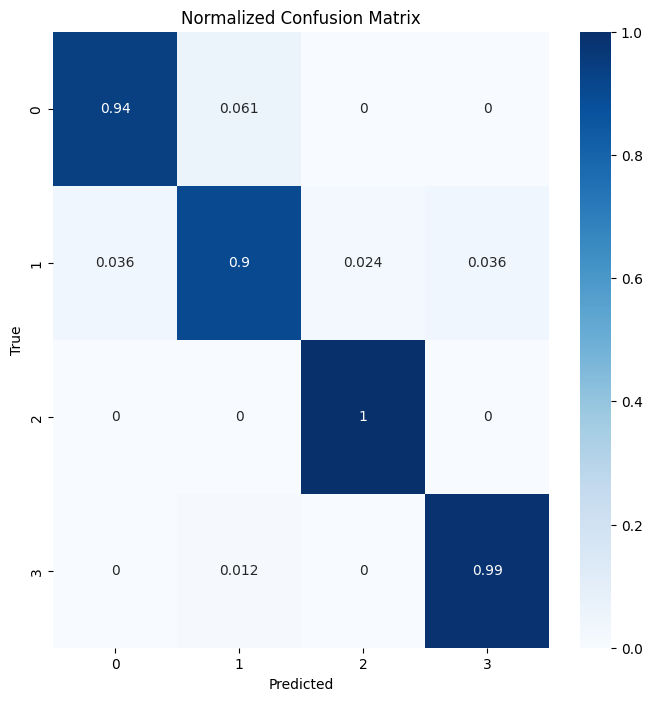

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat_normalized, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

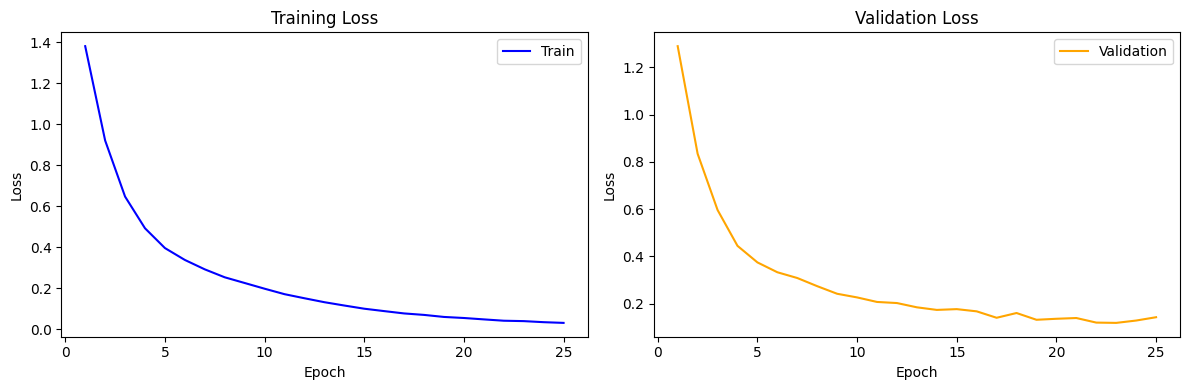

In [ ]:
actual_epochs = len(train_losses)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train Loss 그래프
axes[0].plot(range(1, actual_epochs + 1), train_losses, label='Train', color='blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()

# Validation Loss 그래프
axes[1].plot(range(1, actual_epochs + 1), valid_losses, label='Validation', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Validation Loss')
axes[1].legend()

# 그래프 출력
plt.tight_layout()
plt.show()

Epoch [1/50], Train Loss: 0.0483, Train Accuracy: 0.9963, Train F1: 0.9963, Val Loss: 0.1332, Val Accuracy: 0.9512, Val F1: 0.9509
Early stopping at epoch 1


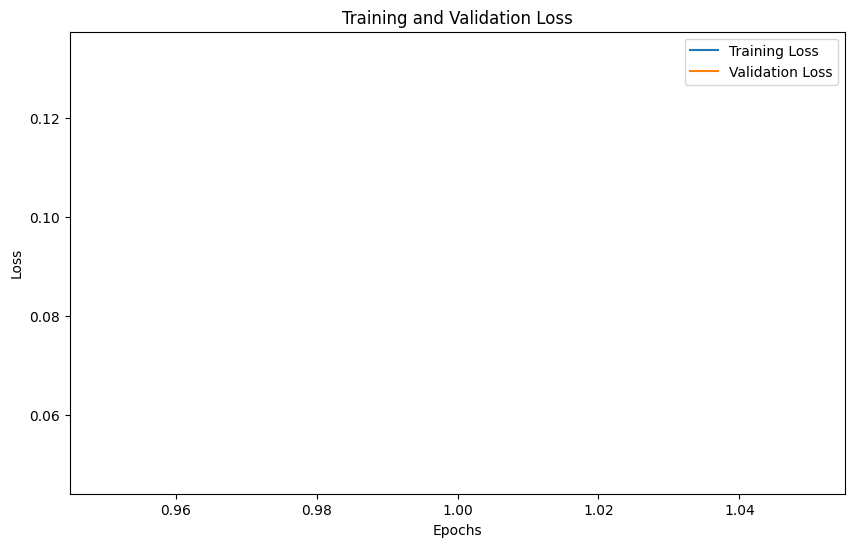

Finished Training


In [ ]:
# Import necessary libraries
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Ensure inline plotting
%matplotlib inline

# Initialize lists for losses
train_losses = []
valid_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_train_preds = []
    all_train_labels = []

    # Training Phase
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Collect predictions and labels for F1 score calculation
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    # Train Accuracy and Loss
    train_acc = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Calculate F1 score for training
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Collect validation predictions and labels for F1 score
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    # Validation Accuracy and Loss
    val_acc = correct_val / total_val
    val_loss = running_val_loss / len(valid_loader)

    # Calculate F1 score for validation
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

    # Track Losses
    train_losses.append(train_loss)
    valid_losses.append(val_loss)

    # Clear previous output for better readability in Jupyter
    clear_output(wait=True)

    # Print metrics for current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1: {train_f1:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}')

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_after.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

print('Finished Training')
